In [2]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [3]:
import numpy as np
import os

# Set CUDA_LAUNCH_BLOCKING
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import sys
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load data

In [4]:
import torch
from peak_detection_2d.config.config import get_cfg_defaults


result_dir = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/"
peak_selection_spec_dir = os.path.join(
    "2d_peak_selection", "exp_wdice_per_image_combo_exp_log_lr001_wdice1"
)
peak_selection_dir = os.path.join(result_dir, peak_selection_spec_dir)
best_model_path = os.path.join(
    peak_selection_dir, "model_backups", "bst_model_0.676.pt"
)
cfg_path = [
    os.path.join(peak_selection_dir, "results", f)
    for f in os.listdir(os.path.join(peak_selection_dir, "results"))
    if f.endswith(".yaml")
]
cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path[0])
torch.manual_seed(cfg.DATASET.RANDOM_STATE)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare confidence dataset 

In [8]:
from peak_detection_2d.model.build_model import build_model
from peak_detection_2d.dataset.dataset import (
    MultiHDF5_MaskDataset,
    build_transformation,
)


h5_path = os.path.join(
    cfg.DATASET.RAW_DATA_PATH,
    cfg.DATASET.ACTIVATION_PATH,
    cfg.DATASET.MODEL_DATA_PATH,
)

# Load data
hdf5_files = [
    os.path.join(h5_path, f) for f in os.listdir(h5_path) if f.endswith(".h5")
]

transformation = build_transformation(cfg.DATASET)
if cfg.DATASET.INPUT_CHANNELS == ["log"]:
    cfg.ONLY_LOG_CHANNEL = True
cfg.MODEL.PARAMS.IN_CHANNELS = cfg.DATASET.N_CHANNEL
logging.info("Dataset channels: %d", cfg.MODEL.PARAMS.IN_CHANNELS)

# Create the dataset
dataset = MultiHDF5_MaskDataset(hdf5_files, transforms=transformation)


# Build model using config dict node
model = build_model(cfg.MODEL)
model.to(DEVICE)

checkpoint = torch.load(best_model_path, map_location=DEVICE)

model.load_state_dict(checkpoint["model_state_dict"])
logging.info("Model loaded from %s", best_model_path)

2024-06-27 13:04:06,468 - root - INFO - Dataset channels: 1


UNET(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(32,

<All keys matched successfully>

2024-06-27 13:04:06,716 - root - INFO - Model loaded from /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice1/model_backups/bst_model_0.676.pt


In [9]:
%autoreload 2
import torch.utils
from peak_detection_2d.dataset.confidence_dataset import (
    prepare_2d_seg_output_and_confidence,
)
from peak_detection_2d.loss.custom_loss import (
    per_image_weighted_iou_metric,
    per_image_weighted_dice_metric,
)
image_dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
# Split the dataset into training and testing sets
train_val_dataset, test_image_dataset = dataset.split_dataset(
    train_ratio=cfg.DATASET.TRAIN_VAL_SIZE, seed=cfg.DATASET.RANDOM_STATE
)
train_image_dataset, val_image_dataset = train_val_dataset.split_dataset(
    train_ratio=cfg.DATASET.TRAIN_SIZE, seed=cfg.DATASET.RANDOM_STATE
)
train_image_dataloader = torch.utils.data.DataLoader(
    train_image_dataset, batch_size=128, shuffle=False
)
val_image_dataloader = torch.utils.data.DataLoader(
    val_image_dataset, batch_size=128, shuffle=False
)
test_image_dataloader = torch.utils.data.DataLoader(
    test_image_dataset, batch_size=128, shuffle=False
)
logging.info("Train dataset size: %d", len(train_image_dataset))
logging.info("Validation dataset size: %d", len(val_image_dataset))
logging.info("Test dataset size: %d", len(test_image_dataset))


2024-06-27 13:04:10,959 - root - INFO - Train dataset size: 25133
2024-06-27 13:04:10,960 - root - INFO - Validation dataset size: 2793
2024-06-27 13:04:10,961 - root - INFO - Test dataset size: 3103


In [8]:
prepare_2d_seg_output_and_confidence(
    dataloader=train_image_dataloader,
    model=model,
    device=DEVICE,
    use_image_for_metric=True,
    metric=per_image_weighted_iou_metric,
    save_hdf5=os.path.join(
        peak_selection_dir, "confidence_dataset", "train_confidence_dataset.h5"
    ),
)

100%|██████████| 197/197 [11:57<00:00,  3.64s/it]
2024-06-25 08:33:07,761 - peak_detection_2d.dataset.confidence_dataset - INFO - Saved segmentation mask and confidence score to /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice4_dh5/confidence_dataset/train_confidence_dataset.h5


In [9]:
prepare_2d_seg_output_and_confidence(
    dataloader=val_image_dataloader,
    model=model,
    device=DEVICE,
    use_image_for_metric=True,
    metric=per_image_weighted_iou_metric,
    save_hdf5=os.path.join(
        peak_selection_dir, "confidence_dataset", "val_confidence_dataset.h5"
    ),
)

100%|██████████| 22/22 [00:38<00:00,  1.75s/it]
2024-06-25 08:35:01,988 - peak_detection_2d.dataset.confidence_dataset - INFO - Saved segmentation mask and confidence score to /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice4_dh5/confidence_dataset/val_confidence_dataset.h5


In [10]:
prepare_2d_seg_output_and_confidence(
    dataloader=test_image_dataloader,
    model=model,
    device=DEVICE,
    use_image_for_metric=True,
    metric=per_image_weighted_iou_metric,
    save_hdf5=os.path.join(
        peak_selection_dir, "confidence_dataset", "test_confidence_dataset.h5"
    ),
)

100%|██████████| 25/25 [00:39<00:00,  1.58s/it]
2024-06-25 08:36:51,365 - peak_detection_2d.dataset.confidence_dataset - INFO - Saved segmentation mask and confidence score to /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice4_dh5/confidence_dataset/test_confidence_dataset.h5


# Load Confidence dataset

In [5]:
%autoreload 2
from peak_detection_2d.dataset.confidence_dataset import ConfidenceDataset, Conf_AsBinary
import torch
from torchvision.transforms import Compose
transformation = Compose([Conf_AsBinary()])
train_conf_dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "train_confidence_dataset.h5"), transforms=transformation)
val_conf_dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "val_confidence_dataset.h5"), transforms=transformation)
test_conf_dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "test_confidence_dataset.h5"), transforms=transformation)

train_dataloader = torch.utils.data.DataLoader(train_conf_dataset, batch_size=128)
val_dataloader = torch.utils.data.DataLoader(val_conf_dataset, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_conf_dataset, batch_size=256)

logging.info("Train dataset size: %d", len(train_conf_dataset))
logging.info("Validation dataset size: %d", len(val_conf_dataset))
logging.info("Test dataset size: %d", len(test_conf_dataset))

2024-06-27 12:59:35,394 - numexpr.utils - INFO - Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-06-27 12:59:35,397 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-06-27 12:59:36,089 - root - INFO - Train dataset size: 25133
2024-06-27 12:59:36,091 - root - INFO - Validation dataset size: 2793
2024-06-27 12:59:36,092 - root - INFO - Test dataset size: 3103


In [20]:
(
    newsplit_train_conf_dataset,
    newsplit_val_conf_dataset,
    _,
) = train_conf_dataset.create_splits(test_size=None, val_size=0.12)
logging.info("Train dataset size: %d", len(newsplit_train_conf_dataset))
logging.info("Validation dataset size: %d", len(newsplit_val_conf_dataset))
newsplit_train_conf_dataset = ConfidenceDataset.combine_datasets(
    newsplit_train_conf_dataset,
    val_conf_dataset,
    os.path.join(
        peak_selection_dir, "confidence_dataset", "newsplit_train_confidence_dataset.h5"
    ),
)
logging.info("Train dataset size: %d", len(newsplit_train_conf_dataset))

2024-06-26 06:54:23,519 - root - INFO - Train dataset size: 22117
2024-06-26 06:54:23,520 - root - INFO - Validation dataset size: 3016
2024-06-26 06:56:39,174 - root - INFO - Train dataset size: 24910


In [60]:
ConfidenceDataset.save_dataset_to_hdf5(
    newsplit_val_conf_dataset,
    os.path.join(
        peak_selection_dir, "confidence_dataset", "newsplit_val_confidence_dataset.h5"
    ),
)

In [22]:
logging.info("Train dataset size: %d", len(newsplit_train_conf_dataset))
logging.info("Validation dataset size: %d", len(newsplit_val_conf_dataset))
logging.info("Test dataset size: %d", len(test_conf_dataset))
train_dataloader = torch.utils.data.DataLoader(
    newsplit_train_conf_dataset, batch_size=128
)
val_dataloader = torch.utils.data.DataLoader(newsplit_val_conf_dataset, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_conf_dataset, batch_size=256)

2024-06-26 06:58:09,511 - root - INFO - Train dataset size: 24910
2024-06-26 06:58:09,512 - root - INFO - Validation dataset size: 3016
2024-06-26 06:58:09,513 - root - INFO - Test dataset size: 3103


In [5]:
%autoreload 2
from peak_detection_2d.dataset.confidence_dataset import ConfidenceDataset
import torch
dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "full_confidence_dataset.h5"))
# train_conf_dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "train_confidence_dataset.h5"))
# val_conf_dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "val_confidence_dataset.h5"))
# test_conf_dataset = ConfidenceDataset(os.path.join(peak_selection_dir, "confidence_dataset", "test_confidence_dataset.h5"))
train_conf_dataset, val_conf_dataset, test_conf_dataset = dataset.create_splits(test_size = 0.1, val_size=0.1)
train_dataloader = torch.utils.data.DataLoader(train_conf_dataset, batch_size=128)
val_dataloader = torch.utils.data.DataLoader(val_conf_dataset, batch_size=256)
test_dataloader = torch.utils.data.DataLoader(test_conf_dataset, batch_size=256)

logging.info("Train dataset size: %d", len(train_conf_dataset))
logging.info("Validation dataset size: %d", len(val_conf_dataset))
logging.info("Test dataset size: %d", len(test_conf_dataset))

2024-06-25 18:10:10,534 - root - INFO - Train dataset size: 24823
2024-06-25 18:10:10,537 - root - INFO - Validation dataset size: 3103
2024-06-25 18:10:10,539 - root - INFO - Test dataset size: 3103


Text(0.5, 1.0, 'WIoU: 0.061')

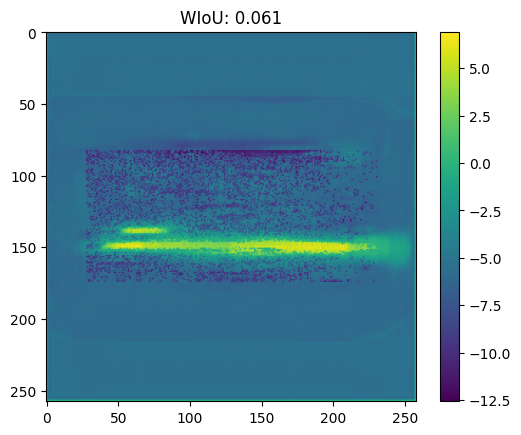

In [6]:
import matplotlib.pyplot as plt

# sample 20 random index from test set
random_idx = np.random.choice(len(test_conf_dataset), 1)
for data_idx in random_idx:
    # logging.info("Show output seg for test data wiou %s", test_dataset[data_idx][1].item())
    plt.imshow(test_conf_dataset[data_idx][0][0].cpu())
    plt.colorbar()
    plt.title("WIoU: " + "{:.3f}".format(test_conf_dataset[data_idx][1].item()))
    # plt.savefig(
    #     os.path.join(
    #         peak_selection_dir,
    #         "confidence_dataset",
    #         f"test_data_{data_itrain_lossdx}_wiou_{test_dataset[data_idx][1].item():.3f}.png",
    #     )
    # )
    # plt.close()

# Train Confidence model

In [ ]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()

31

KeyboardInterrupt: 

In [9]:
from peak_detection_2d.model.conf_model import CNNEncoderRegressor, CNNRegression

from torchinfo import summary

net = CNNEncoderRegressor(downhill=5, first_out_channels=32)

summary(
    model=net,
    # (batch_size, color_channels, height, width)
    input_size=(8, 1, 258, 258),
    col_names=["input_size", "output_size", "num_params"],
    col_width=20,
    row_settings=["var_names"],
    depth=4,
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #
CNNEncoderRegressor (CNNEncoderRegressor)               [8, 1, 258, 258]     [8, 1]               --
├─Encoder (encoder)                                     [8, 1, 258, 258]     [8, 1024, 4, 4]      --
│    └─ModuleList (enc_layers)                          --                   --                   --
│    │    └─CNNBlocks (0)                               [8, 1, 258, 258]     [8, 32, 256, 256]    --
│    │    │    └─ModuleList (layers)                    --                   --                   9,632
│    │    └─MaxPool2d (1)                               [8, 32, 256, 256]    [8, 32, 128, 128]    --
│    │    └─CNNBlocks (2)                               [8, 32, 128, 128]    [8, 64, 126, 126]    --
│    │    │    └─ModuleList (layers)                    --                   --                   55,552
│    │    └─MaxPool2d (3)                               [8, 64, 126, 126]    [8

In [6]:
%autoreload 2

import torcheval
from peak_detection_2d.model.conf_model import ConfidenceModel, CNNRegression, train_one_epoch, evaluate, CNNEncoderRegressor
from peak_detection_2d.utils import EarlyStopping
from torcheval.metrics.functional import binary_auprc
conf_model = CNNEncoderRegressor(downhill=5)
conf_model.to(DEVICE)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCELoss()
#criterion = FocalLoss()
optimizer = torch.optim.Adam(conf_model.parameters(), lr=0.001)
EPOCHS = 100
patience = 10
es = EarlyStopping(patience=patience, mode="max")
train_loss = []
metric = {"train": [], "val": []}
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=100)
# es = EarlyStopping(patience=patience, mode="max")
for epoch in range(EPOCHS):
    loss = train_one_epoch(
        train_loader=train_dataloader, model=conf_model, optimizer=optimizer, loss_fn = criterion, 
        device = DEVICE, scheduler=scheduler
    )
    train_metric = evaluate(
        train_dataloader,
        conf_model,
        metric=binary_auprc,
        device=DEVICE,
    )
    val_metric = evaluate(
        val_dataloader,
        conf_model,
        metric=binary_auprc,
        device=DEVICE,
    )
    metric["train"].append(train_metric)
    metric["val"].append(val_metric)
    train_loss.append(loss)
    if scheduler is not None and scheduler.__class__.__name__!= "OneCycleLR":
        if scheduler.__class__.__name__ == "ReduceLROnPlateau":
            scheduler.step(val_metric)
        else:
            scheduler.step()
    print(
        f"EPOCH: {epoch}, TRAIN LOSS: {loss}, TRAIN MAE: {train_metric}, VAL MAE:"
        f" {val_metric}"
    )
    es(
        epoch_score=val_metric,
        epoch_num=epoch,
        loss=loss,
        optimizer=optimizer,
        model=conf_model,
        model_path=os.path.join(
            peak_selection_dir,"confidence_dataset",
            f"bst_model_{np.round(val_metric,4)}.pt",
        ),
        scheduler=scheduler,

    )
    best_conf_model = os.path.join(
        peak_selection_dir,
        "confidence_dataset",
        f"bst_model_{np.round(-1*es.best_score,4)}.pt",
    )
    if es.early_stop:
        print("\n\n -------------- EARLY STOPPING -------------- \n\n")
        break

CNNEncoderRegressor(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16, 32, kernel_size=

100%|██████████| 11/11 [00:03<00:00,  3.14it/s, loss=0.916]


EPOCH: 0, TRAIN LOSS: 0.4072020942638368, TRAIN MAE: 0.9555852349639544, VAL MAE: 0.9155320254239169
Validation score improved (-inf --> 0.9155320254239169). Model saved at at /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice1/confidence_dataset/bst_model_0.9155.pt!


100%|██████████| 11/11 [00:02<00:00,  5.19it/s, loss=0.931]


EPOCH: 1, TRAIN LOSS: 0.3421106028375287, TRAIN MAE: 0.9636002004449138, VAL MAE: 0.930808040228757
Validation score improved (0.9155320254239169 --> 0.930808040228757). Model saved at at /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice1/confidence_dataset/bst_model_0.9308.pt!


100%|██████████| 11/11 [00:02<00:00,  4.70it/s, loss=0.933]


EPOCH: 2, TRAIN LOSS: 0.32535366002980826, TRAIN MAE: 0.9668588562665252, VAL MAE: 0.9330228621309454
Validation score improved (0.930808040228757 --> 0.9330228621309454). Model saved at at /cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_exp_log_lr001_wdice1/confidence_dataset/bst_model_0.933.pt!


KeyboardInterrupt: 

# Evaluation

In [25]:
# best_conf_model = os.path.join(
#     peak_selection_dir, "confidence_dataset", "bst_model_0.1337.pt"
# )
from peak_detection_2d.model.conf_model import (
    inference_and_sum_intensity,
    CNNEncoderRegressor,
)

conf_model = CNNEncoderRegressor(downhill=5, first_out_channels=16)
checkpoint = torch.load(best_conf_model, map_location=DEVICE)
conf_model.load_state_dict(checkpoint["model_state_dict"])
conf_model.to(DEVICE)

<All keys matched successfully>

CNNEncoderRegressor(
  (encoder): Encoder(
    (enc_layers): ModuleList(
      (0): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): CNNBlocks(
        (layers): ModuleList(
          (0): CNNBlock(
            (seq_block): Sequential(
              (0): Conv2d(16, 32, kernel_size=

In [73]:
from peak_detection_2d.config.config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg_path = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/frame0_1830_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.9_threshold_missabthres0.5_convergence_NoIntercept_pred_mzBinDigits2_imPeakWidth4_deltaMobilityThres80/2d_peak_selection/exp_wdice_per_image_combo_two_channel_exp_log_lr001_wdice4_dh5/results/config_2024-06-26T11_23_31.746031.yaml"
cfg.merge_from_file(cfg_path)
cfg.merge_from_file(
    "/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/peak_detection_2d/config/exp_calib/test.yaml"
)

In [36]:
avg_loss, other_outputs = evaluate(
    valid_loader=test_dataloader,
    model=conf_model,
    metric=torch.nn.L1Loss(reduction="none"),
    device=DEVICE,
    save_all_loss=True,
    save_output_prediction=True,
    save_target=True,
)
import pandas as pd

other_outputs_df = pd.DataFrame(other_outputs)
other_outputs_df.output_pred.corr(other_outputs_df.target)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:10<00:00,  1.29it/s, loss=0.158]


0.6963290766801259

In [12]:
%autoreload 2
from peak_detection_2d.model.conf_model import (
    inference_and_sum_intensity,
)

test_df = inference_and_sum_intensity(
    data_loader=test_image_dataloader,
    model=model,
    device=DEVICE,
    calc_score="conf_model",
    conf_model=conf_model,
    exp = True
)

In [28]:
test_df["binary_label"] = test_df["wiou"] > 0.5
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)

print(classification_report(test_df["binary_label"], test_df["out_score"] > 0.5)),
roc_auc_score(test_df["binary_label"], test_df["out_score"]),
average_precision_score(test_df["binary_label"], test_df["out_score"])

              precision    recall  f1-score   support

       False       0.68      0.41      0.51       931
        True       0.78      0.92      0.85      2172

    accuracy                           0.77      3103
   macro avg       0.73      0.67      0.68      3103
weighted avg       0.75      0.77      0.75      3103



(None,)

(0.8444339934287178,)

0.9257458375256399

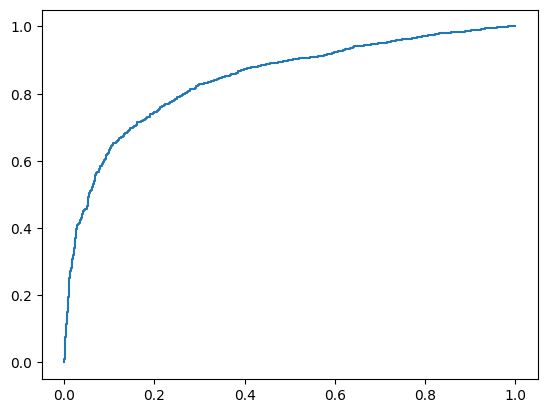

In [29]:
from sklearn.metrics import roc_curve

plt.plot(
    roc_curve(test_df["binary_label"], test_df["out_score"])[0],
    roc_curve(test_df["binary_label"], test_df["out_score"])[1],
)

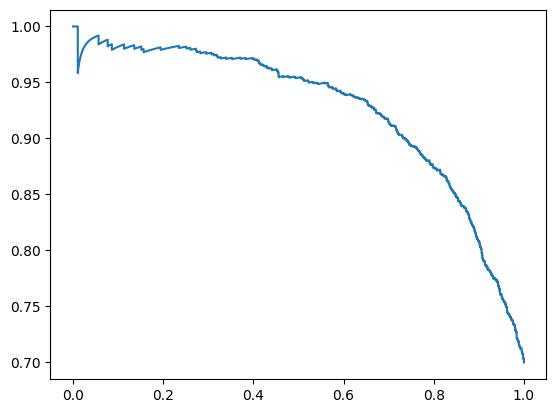

: 

In [30]:
prcurve = precision_recall_curve(test_df["binary_label"], test_df["out_score"])
plt.plot(prcurve[1], prcurve[0])

In [63]:
test_df = pd.read_csv(
    os.path.join(
        peak_selection_dir,
        "20240626_082233633434",
        "conf_model_results",
        "test_results.csv",
    )
)

In [20]:
%autoreload 2
from peak_detection_2d.model.conf_model import (
    inference_and_sum_intensity,
)

val_df = inference_and_sum_intensity(
    data_loader=val_image_dataloader,
    model=model,
    device=DEVICE,
    calc_score="conf_model",
    conf_model=conf_model,
    exp = True
)

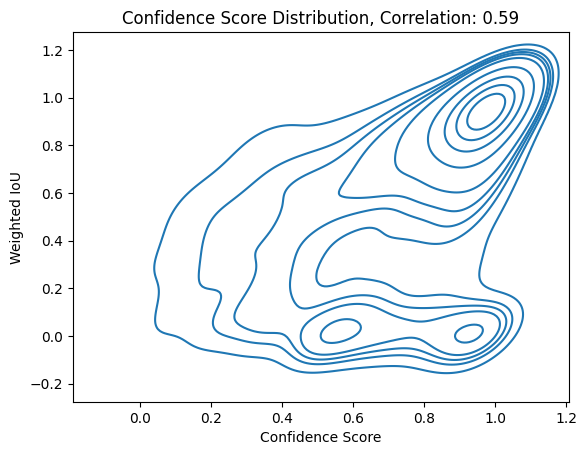

In [13]:
from peak_detection_2d.utils import plot_confidence_distr

plot_confidence_distr(test_df, save_dir=None)

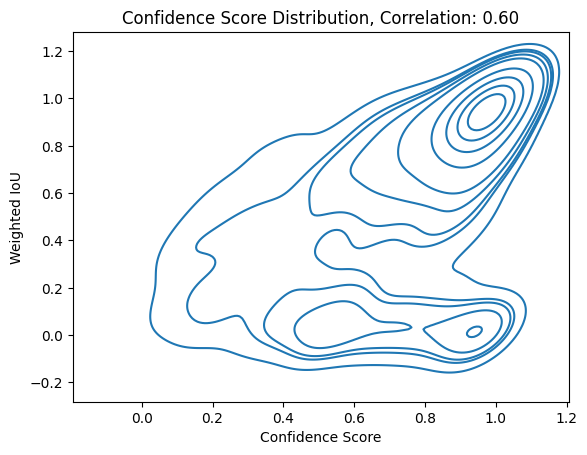

In [21]:
plot_confidence_distr(val_df, save_dir=None)

In [15]:
import plotly.express as px

test_df["label_sum_intensity_log"] = np.log10(test_df["label_sum_intensity"] + 1)
px.scatter(
    data_frame=test_df,
    x="out_score",
    y="wiou",
    color="label_sum_intensity_log",
    hover_data=[
        "pept_mz_rank",
        test_df.index,
    ],
)

2024-06-26 08:57:48,077 - peak_detection_2d.utils - INFO - Confidence score: 0.3961251676082611


2024-06-26 08:57:48,107 - peak_detection_2d.utils - INFO - Masked area 1232.0
2024-06-26 08:57:48,109 - peak_detection_2d.utils - INFO - Masked intensity sum 2438.96
2024-06-26 08:57:48,110 - peak_detection_2d.utils - INFO - Pred masked intensity sum 2414.10


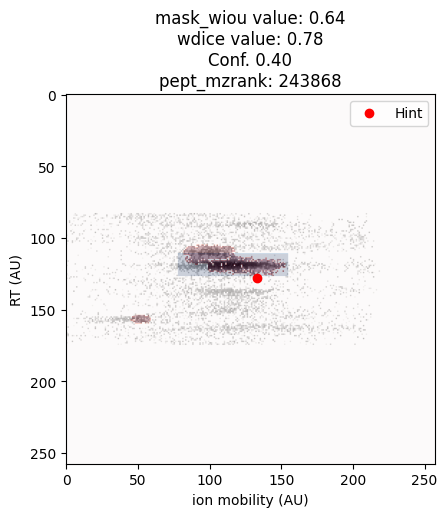

In [71]:
import matplotlib.pyplot as plt
from peak_detection_2d.utils import plot_sample_predictions

data_idx = 443

plot_sample_predictions(
    dataset=test_image_dataset,
    model=model,
    conf_model=conf_model,
    sample_indices=[data_idx],
    device=DEVICE,
    label="mask",
    save_dir=None,
    use_hint=False,
    zoom_in=False,
    metric_list=["mask_wiou", "wdice"],
)

<Axes: >

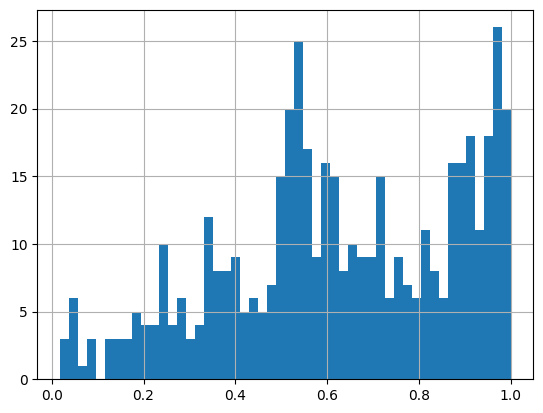

In [18]:
test_df.loc[test_df["wiou"] <= 0.1]["out_score"].hist(bins=50)

<Axes: >

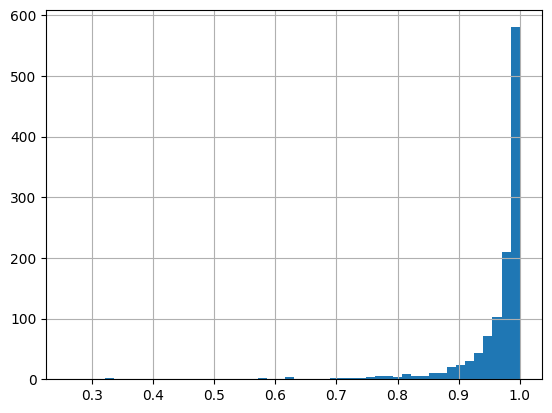

In [19]:
test_df.loc[test_df["wiou"] >= 0.9]["out_score"].hist(bins=50)

<Axes: >

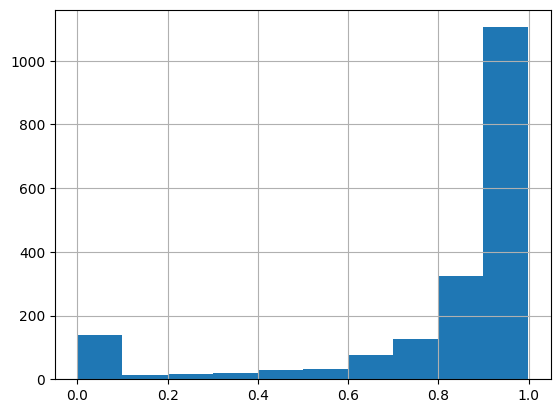

In [40]:
test_df.loc[test_df["out_score"] > 0.6, "wiou"].hist()

## Correlation of sum_intensitys

2024-06-27 13:06:18,498 - result_analysis.result_analysis - INFO - Reference shape: (31029, 32)


Data:  Intensity_log sum_intensity_log , slope =  0.851 , intercept =  0.349 , PearsonR =  0.821 , SpearmanR =  0.812


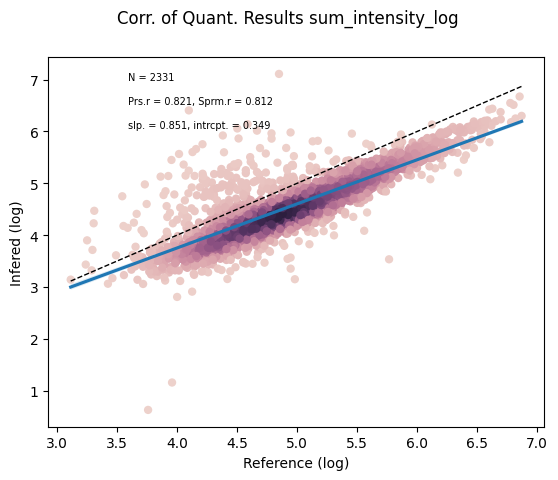

In [16]:
from result_analysis.result_analysis import SBSResult
import pandas as pd

maxquant_merge = pd.read_pickle(
    os.path.join(result_dir, "maxquant_result_merged_cleaned.pkl")
)
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_merge,
    maxquant_merge_df=maxquant_merge,
    maxquant_exp_df=None,
    sum_raw=test_df.loc[test_df["out_score"] >= 0.6],
    # sum_raw=val_df.loc[val_df["out_score"] >= 0.4],
    # sum_gaussian=train_label_df,
    ims=True,
)
sbs_ims_result.plot_intensity_corr(
    ref_col="Intensity", inf_col="sum_intensity", contour=False
)

## Samples with low IoU

<Axes: xlabel='log_label_intensity', ylabel='log_pred_intensity'>

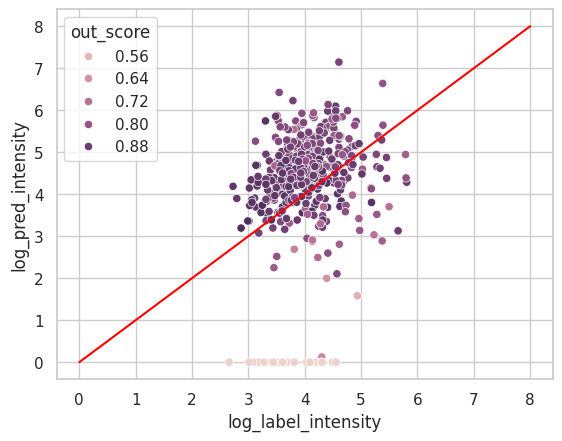

In [82]:
from matplotlib import cm
from pyparsing import col


# set grid in the background
sns.set(style="whitegrid")
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_label_intensity",
    y="log_pred_intensity",
    hue="out_score",
    hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)
plt.plot([0, 8], [0, 8], color="red")

<Axes: xlabel='log_pred_intensity', ylabel='out_score'>

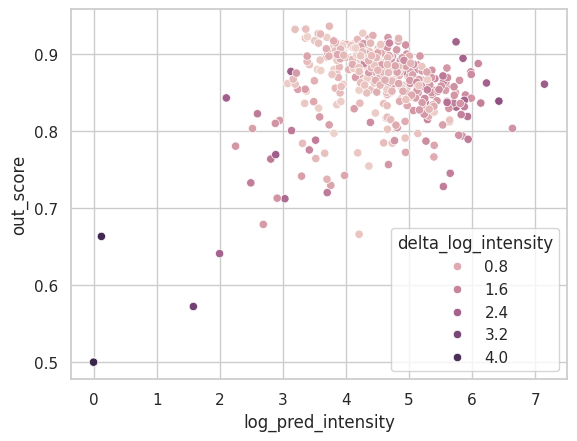

In [91]:
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_pred_intensity",
    y="out_score",
    hue="delta_log_intensity",
    # hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)

<Axes: xlabel='losses', ylabel='out_score'>

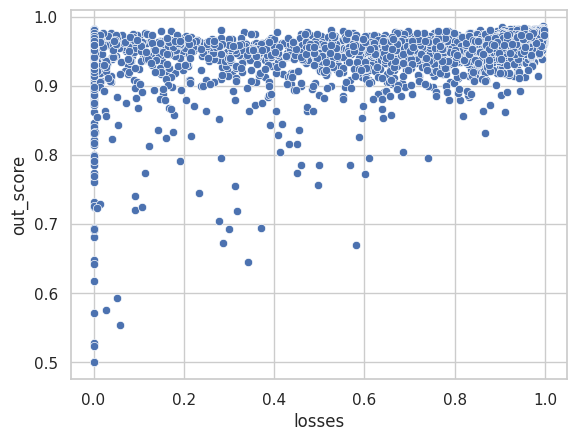

In [111]:
# Evaluating miscalibration
sns.scatterplot(
    # data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    data=test_all_df,
    x="losses",
    y="out_score",
    # hue="delta_log_intensity",
    # hue_norm=(0.5, 1),
    # color=cm.get_cmap("coolwarm"),
)

In [ ]:
sns.scatterplot(
    data=test_all_df.loc[test_all_df["losses"] <= 0.1],
    x="log_label_intensity",
    y="log_pred_intensity",
    size="out_score",
    # color=cm.get_cmap("coolwarm"),
)

In [80]:
from peak_detection_2d.utils import plot_sample_predictions
import pandas as pd

ind_all_wiou = pd.DataFrame(ind_all_wiou)
# get indices of the top 10 worst performing images
worst_performing_images = ind_all_wiou["losses"].sort_values(ascending=True).index[:10]

# Plot sample predictions
plot_sample_predictions(
    test_image_dataset,
    model=bst_model,
    sample_indices=worst_performing_images,
    # n = 10,
    # save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions_lowest_wiou"),
)

2024-06-06 16:19:17,937 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-06 16:19:17,938 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 2, 258, 258])
2024-06-06 16:19:17,964 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 258, 258])
2024-06-06 16:19:17,965 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

In [82]:
best_performing_images = (
    ind_all_wiou["losses"].sort_values(ascending=False).index[50:60]
)

# Plot sample predictions
plot_sample_predictions(
    test_image_dataset,
    model=bst_model,
    sample_indices=best_performing_images,
    # n = 10,
    # save_dir=None,
    metric_list=["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in=False,
    label="mask",
    device=DEVICE,
    save_dir=os.path.join(peak_selection_dir, "sample_predictions_highest_wiou"),
)

2024-06-06 16:21:26,036 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-06 16:21:26,037 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 2, 258, 258])
2024-06-06 16:21:26,038 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 258, 258])
2024-06-06 16:21:26,039 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding

In [84]:
from peak_detection_2d.utils import plot_per_image_metric_distr

plot_per_image_metric_distr(
    ind_all_wiou["losses"], "Weighted_IoU", save_dir=peak_selection_dir
)
plot_per_image_metric_distr(
    ind_all_wdice["losses"], "Weighted_Dice", save_dir=peak_selection_dir
)

25%: 0.14
50%: 0.78
75%: 0.95
25%: 0.25
50%: 0.88
75%: 0.97


In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

31

31

In [20]:
%autoreload 2
from peak_detection_2d.utils import plot_sample_predictions

# Plot sample predictions
plot_sample_predictions(
    test_image_dataset,
    model=bst_model,
    sample_indices=[1420, 2409, 1483, 2101,  68, 3003, 2973, 2182, 2311, 2606],
    #n = 10,
    #save_dir=None,
    metric_list = ["mask_wiou", "wdice", "dice"],
    use_hint=False,
    zoom_in = False,
    label = 'mask',
    save_dir=os.path.join(peak_selection_dir, "sample_predictions"),
)

2024-06-03 16:25:35,331 - peak_detection_2d.seg_model - DEBUG - Layer: CNNBlocks(
  (layers): ModuleList(
    (0): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): CNNBlock(
      (seq_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
)
2024-06-03 16:25:35,332 - peak_detection_2d.seg_model - DEBUG - Input x shape: torch.Size([1, 1, 178, 178])
2024-06-03 16:25:35,333 - peak_detection_2d.seg_model - DEBUG - Output shape: torch.Size([1, 32, 178, 178])
2024-06-03 16:25:35,334 - peak_detection_2d.seg_model - DEBUG - Layer: MaxPool2d(kernel_size=2, stride=2, padding